# ensemble learning
## voting method

In [ ]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning

from typing import List, Literal
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix
from _functions import custom_classification_report, plot_confusion_matrix, get_best_threshold_i
from matplotlib import pyplot as plt

warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

plt.ioff()

In [2]:
# custom voting classifier class
class VotingClassifier():
    def __init__(self, model_list: List[tuple]):
        self.model_tuples = model_list
        self.model_names = [model_tup[0] for model_tup in model_list]
        self.models = [model_tup[1] for model_tup in model_list]

    Voting_mode = Literal['max', 'mean', 'median', 'min']
    voting_func = [np.max, np.mean, np.median, np.min]

    def get_representative_val(self, y_pred_list, voting: Voting_mode):
        func_dict = {mode: func for mode, func in zip(VotingClassifier.Voting_mode.__args__, VotingClassifier.voting_func)}
        func = func_dict[voting]
        return func(y_pred_list, axis=0)
    
    def predict(self, X, voting: Voting_mode):
        assert all([hasattr(model, 'predict') for model in self.models])
        
        y_pred_list = [model.predict(X) for model in self.models]
        y_pred = self.get_representative_val(y_pred_list, voting=voting)
        return y_pred

    def predict_proba(self, X, voting: Voting_mode):
        assert all([hasattr(model, 'predict_proba') for model in self.models])

        y_pred_list = [model.predict_proba(X) for model in self.models]
        y_pred = self.get_representative_val(y_pred_list, voting=voting)
        return y_pred

In [3]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [4]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']
y_col = ['fraudulent']

df2 = df[X_numeric_cols + X_text_cols + X_cat_cols + y_col].dropna()
# df2 = df.loc[:300, X_numeric_cols + X_text_cols + X_cat_cols + y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col].values.ravel()  # Convert to 1D array

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Training shape: (14426, 12)
Test shape: (3607, 12)


In [ ]:
models_dict = {
    'model_dt': None,
    'model_lr': None,
    'model_rf': None,
    'model_svm': None,
    'model_xgb': None,
    'model_nn': None
}

path_dict = {
    'model_dt': 'models/decision_tree_model_k=5.pkl',
    'model_lr': 'models/logistic_regression_model_k=5.pkl',
    'model_rf': 'models/rf_model_k=5.pkl',
    'model_svm': 'models/svm_model_k=5.pkl',
    'model_xgb': 'models/xgboost_model_k=5.pkl',
    'model_nn': 'models/nn_model_k=5.pkl'   
}

# load all models
for model_name, model in models_dict.items():
    with open(path_dict[model_name], 'rb') as saved_model:
        models_dict[model_name] = pickle.load(saved_model)

Classification Report (Mode: max):
           precision    recall  f1-score  f2-score   support

Not Fraud      0.994     0.958     0.976     0.965      3361
    Fraud      0.617     0.919     0.739     0.837       246

 accuracy                                    0.956      3607

Classification Report (Mode: mean):
           precision    recall  f1-score  f2-score   support

Not Fraud      0.991     0.994     0.992     0.993      3361
    Fraud      0.911     0.874     0.892     0.881       246

 accuracy                                    0.986      3607

Classification Report (Mode: median):
           precision    recall  f1-score  f2-score   support

Not Fraud      0.991     0.994     0.992     0.993      3361
    Fraud      0.911     0.874     0.892     0.881       246

 accuracy                                    0.986      3607

Classification Report (Mode: min):
           precision    recall  f1-score  f2-score   support

Not Fraud      0.982     0.999     0.991     0.996   

<Figure size 600x500 with 0 Axes>

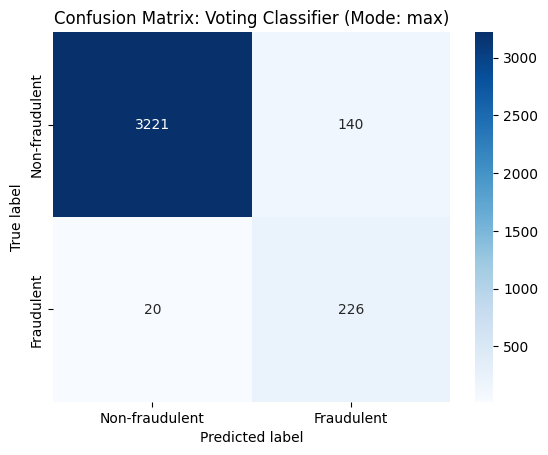

<Figure size 600x500 with 0 Axes>

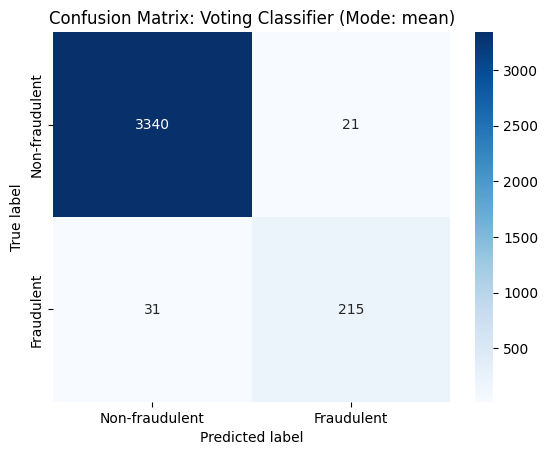

<Figure size 600x500 with 0 Axes>

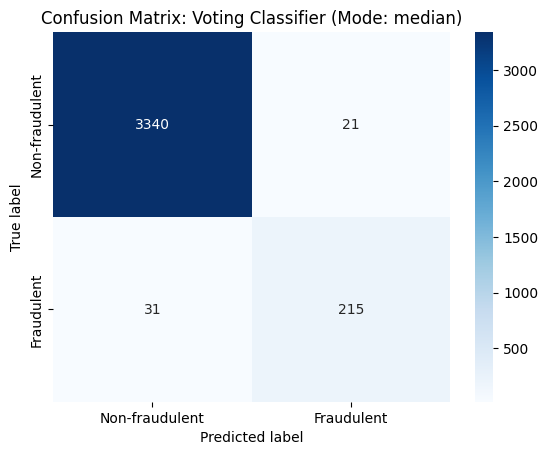

<Figure size 600x500 with 0 Axes>

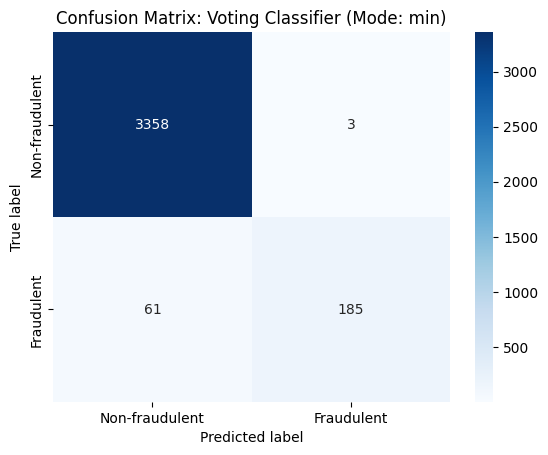

In [27]:
voting_model = VotingClassifier(
    [(model_name, models_dict[model_name]) for model_name in ['model_svm', 'model_xgb', 'model_rf']]
)


voting_modes = ['max', 'mean', 'median', 'min']

for voting_mode in voting_modes:
    y_pred = (voting_model.predict(X_test, voting=voting_mode) > 0.5).astype(int)

    print(f"Classification Report (Mode: {voting_mode}):")
    print(custom_classification_report(y_test, y_pred, digits=3))
    fig, ax = plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"Confusion Matrix: Voting Classifier (Mode: {voting_mode})")

In [ ]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = f'models/ensemble_voting_classifier.pkl'
with open(filename, 'wb') as file:
    pickle.dump(voting_model, file)